In [5]:
import logging
import re
from pathlib import Path
from tqdm import tqdm
import numpy as np



from datamaestro import prepare_dataset
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import copy as cp
from typing import List, Tuple, Dict, Set, Union, Iterable, Callable, TypeVar, Optional
from torchmetrics.classification import BinaryAccuracy
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import tensorboard
import matplotlib.pyplot as plt

In [6]:
class FolderText(Dataset):
    """Dataset basé sur des dossiers (un par classe) et fichiers"""

    def __init__(self, classes, folder: Path, tokenizer, load=False):
        self.tokenizer = tokenizer
        self.files = []
        self.filelabels = []
        self.labels = {}
        for ix, key in enumerate(classes):
            self.labels[key] = ix

        for label in classes:
            for file in (folder / label).glob("*.txt"):
                self.files.append(file.read_text() if load else file)
                self.filelabels.append(self.labels[label])

    def __len__(self):
        return len(self.filelabels)

    def __getitem__(self, ix):
        s = self.files[ix]
        return self.tokenizer(s if isinstance(s, str) else s.read_text()), self.filelabels[ix]
    
    @staticmethod
    def collate(batch):
        data = [torch.LongTensor(item[0]) for item in batch]
        labels = [item[1] for item in batch]
        return pad_sequence(data,padding_value=400001 ,batch_first=True), torch.LongTensor(labels)

def get_imdb_data(embedding_size=50):
    """Renvoie l'ensemble des donnéees nécessaires pour l'apprentissage

    - dictionnaire word vers ID
    - embeddings (Glove)
    - DataSet (FolderText)

    """
    WORDS = re.compile(r"\S+")

    words, embeddings = prepare_dataset('edu.stanford.glove.6b.%d' % embedding_size).load()
    OOVID = len(words)
    words.append("__OOV__")

    word2id = {word: ix for ix, word in enumerate(words)}
    embeddings = np.vstack((embeddings, np.zeros(embedding_size)))

    def tokenizer(t):
        return [word2id.get(x, OOVID) for x in re.findall(WORDS, t.lower())]

    logging.info("Loading embeddings")

    logging.info("Get the IMDB dataset")
    ds = prepare_dataset("edu.stanford.aclimdb")

    return word2id, embeddings, FolderText(ds.train.classes, ds.train.path, tokenizer, load=False), FolderText(ds.test.classes, ds.test.path, tokenizer, load=False)

In [7]:
class model_1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # Input layer to hidden layer
            nn.ReLU(),  # Activation function (ReLU)
            nn.Linear(hidden_size, hidden_size),  # Hidden layer to output layer
            nn.ReLU(),  # Activation function (ReLU)
            nn.Linear(hidden_size, hidden_size),  # Hidden layer to output layer
            nn.ReLU(),  # Activation function (ReLU)
            nn.Linear(hidden_size, output_size), # Hidden layer to output layer
            nn.Sigmoid() # Hidden layer to output layer
        )

    def forward(self, x):
        x = x.mean(dim=1)
        x = self.model(x)
        return x

In [8]:
def eval(model, val_loader, device, criterion, writer, write_tensorboard, epoch):
    model.eval()

    acc_eval = BinaryAccuracy().to(device) 

    epoch_loss = []
    epoch_accuracy = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.float().to(device)
            logits = model(data).view(-1)
            loss = criterion(logits, target)
            
            epoch_loss.append(loss.item())
            batch_accuracy = acc_eval(logits, target)
            epoch_accuracy.append(batch_accuracy.item())


        """
        if write_tensorboard:

            writer.add_scalar('Loss validation', np.mean(epoch_loss), epoch)
        
            for name, weight in model.named_parameters():
                writer.add_histogram(name, weight, epoch)
                writer.add_histogram(f'{name}.grad', weight.grad, epoch)

            entropie = criterion(logits,target)
            writer.add_histogram('Entropy validation', entropie, epoch)
            
            writer.add_scalar('Accuracy validation', np.mean(epoch_accuracy), epoch)
        """

        return np.mean(epoch_loss), np.mean(epoch_accuracy) 
        

In [22]:
def train(model, optimizer, train_loader, val_loader, nb_epoch, device, writer):
    criterion = nn.BCELoss().to(device) 
    acc_train = BinaryAccuracy().to(device) 
    loss_values = []
    accuracy_values = [] 
    loss_eval = []
    accuracy_values_eval = [] 
    write_tensorboard_train = nb_epoch//20

    for epoch in range(nb_epoch):
        write_tensorboard = write_tensorboard_train != 0 and epoch % write_tensorboard_train == 0

        model.train()
        epoch_loss = []
        epoch_accuracy = []

        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.float().to(device)
            optimizer.zero_grad()

            logits = model(data).view(-1)
            loss = criterion(logits, target)

            epoch_loss.append(loss.item())
            batch_accuracy = acc_train(logits, target)
            epoch_accuracy.append(batch_accuracy.item())

            loss.backward()
            optimizer.step()


        loss_values.append(np.mean(epoch_loss))
        accuracy_values.append(np.mean(epoch_accuracy))

        """
        if write_tensorboard:

            writer.add_scalar('Loss train', np.mean(epoch_loss), epoch)
        
            for name, weight in model.named_parameters():
                writer.add_histogram(f'{name}', weight, epoch)
                writer.add_histogram(f'{name}.grad', weight.grad, epoch)

            entropie = criterion(logits,target)
            writer.add_histogram('Entropy train', entropie, epoch)
            
            writer.add_scalar('Accuracy train', np.mean(epoch_accuracy), epoch)

        """

        epoch_loss_eval, epoch_acc_eval = eval(model, val_loader, device, criterion, writer, write_tensorboard, epoch)
        loss_eval.append(epoch_loss_eval)
        accuracy_values_eval.append(epoch_acc_eval)

        
    return loss_values, accuracy_values, loss_eval, accuracy_values_eval


## Modèle de base

In [49]:
class Model(nn.Module):
    def __init__(self, embeddings, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.emb = torch.nn.Embedding.from_pretrained(torch.FloatTensor(embeddings)).requires_grad_(False)
        self.mlp= nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size), 
            nn.Sigmoid() 
        )

    def forward(self, x):
        x_emb = self.emb(x)
        #print("emb : ",x_emb.shape)

        x_mean = torch.mean(x_emb, dim=1)
        #print("mean : ", x_mean.shape)

        x = self.mlp(x_mean)
        #print("mlp : ", x.shape)

        return x

In [50]:
word2vec, embeddings, train_data, test_data = get_imdb_data()
word2vec['pad'] = 400001
embeddings = np.vstack((np.array(embeddings),np.zeros((1,50))))
train_dataset = DataLoader(train_data, collate_fn= FolderText.collate, batch_size=32, shuffle=True)
test_dataset = DataLoader(test_data,collate_fn=FolderText.collate, batch_size=32, shuffle=True)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
input_size = 50
hidden_size = 25
output_size = 1
lr = 0.001

mlp = Model(embeddings,input_size, hidden_size, output_size).to(device)
critere = nn.BCELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

writer = SummaryWriter()



Using device: cpu


In [52]:
loss_values, accuracy_values, loss_eval, accuracy_values_eval = train(mlp, optim, train_dataset, test_dataset,10, device, writer)

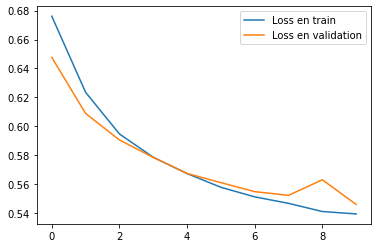

In [53]:

plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

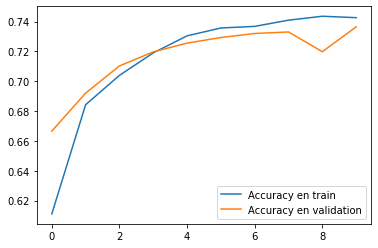

In [54]:

plt.figure()
plt.plot(accuracy_values,label="Accuracy en train")
plt.plot(accuracy_values_eval,label="Accuracy en validation")
plt.legend()
plt.show()

## Attention simple

In [55]:
class AttentionSimple(nn.Module):
    def __init__(self, embeddings,input_size,hidden_size, output_size):
        super(AttentionSimple, self).__init__()
        self.emb = torch.nn.Embedding.from_pretrained(torch.FloatTensor(embeddings)).requires_grad_(False)
        self.emb_q = nn.Linear(input_size, output_size, bias=False) #//un vecteur de taille input_size que veut apprendre pour multpiplier avec x_k

        self.mlp= nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size), 
            nn.Sigmoid() 
        )

    def forward(self, x):
        
        x_k = self.emb(x)
        #print('x_k: ', x_k.shape)
        
        x_q = self.emb_q(x_k) 
        #print('x_q: ', x_q.shape) 
        
        attention = F.softmax(x_q, dim=1) 
        #print('attention: ', attention.shape) 
        
        x_weighted= attention*x_k 
        #print('x_weighted: ', x_weighted.shape)
        
        x = torch.sum(x_weighted, dim=1)
        #print('x_sum: ', x.shape)
        
        x = self.mlp(x)
        #print('x mlp: ', x.shape)

        return x

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
input_size = 50
hidden_size = 25
output_size = 1
lr = 0.001

mlp = AttentionSimple(embeddings,input_size, hidden_size, output_size).to(device)
critere = nn.BCELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

writer = SummaryWriter()



Using device: cpu


In [57]:
loss_values, accuracy_values, loss_eval, accuracy_values_eval = train(mlp, optim, train_dataset, test_dataset,10, device, writer)

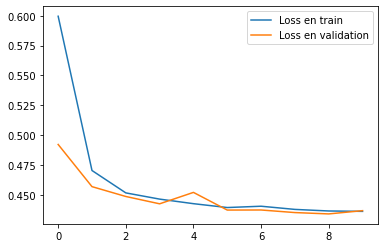

In [58]:

plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

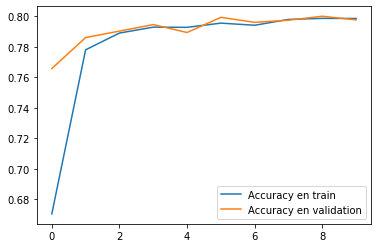

In [59]:

plt.figure()
plt.plot(accuracy_values,label="Accuracy en train")
plt.plot(accuracy_values_eval,label="Accuracy en validation")
plt.legend()
plt.show()

## Question et valeur

In [102]:
class Attention(nn.Module):
    def __init__(self, embeddings,input_size,hidden_size, output_size):
        super(Attention, self).__init__()
        self.emb = torch.nn.Embedding.from_pretrained(torch.FloatTensor(embeddings)).requires_grad_(False)

        self.lin_q = nn.Linear(input_size, input_size)
        self.lin_v = nn.Linear(input_size, input_size)


        self.mlp= nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size), 
            nn.Sigmoid() 
        )

    def forward(self, x):
        
        x_emb = self.emb(x)
        #print('x_emb: ', x_emb.shape)

        t_hat = torch.mean(x_emb, dim=1)
        #print("mean : ", t_hat.shape)

        q = self.lin_q(t_hat).unsqueeze(1)
        #print("query : ", q.shape)

        attention = F.softmax(x_emb @ q.transpose(1,2), dim=1) 
        #print("attention : ", attention.shape)

        v = self.lin_v(x_emb)
        #print("v: ", v.shape)

        v_att = v*attention
        #print('v_att: ', v_att.shape)

        v_weighted = torch.sum(v, dim=1)
        print('v_weighted: ', v_weighted.shape)
        
        x = self.mlp(v_weighted)
        print('x mlp: ', x.shape)

        return x

In [103]:
model = Attention(embeddings ,50, 20, 1)
for i, (data,target) in enumerate(train_dataset): 
    print(data.shape)
    data = model(data)
    break

torch.Size([32, 818])
x_emb:  torch.Size([32, 818, 50])
mean :  torch.Size([32, 50])
query :  torch.Size([32, 1, 50])
attention :  torch.Size([32, 818, 1])
v:  torch.Size([32, 818, 50])
v_att:  torch.Size([32, 818, 50])
v_weighted:  torch.Size([32, 50])
x mlp:  torch.Size([32, 1])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
input_size = 50
hidden_size = 25
output_size = 1
lr = 0.001

mlp = AttentionSimple(embeddings,input_size, hidden_size, output_size).to(device)
critere = nn.BCELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

writer = SummaryWriter()

In [ ]:
loss_values, accuracy_values, loss_eval, accuracy_values_eval = train(mlp, optim, train_dataset, test_dataset,10, device, writer)